In [1]:
import os
os.chdir('/Users/beth/Documents/Metis/metis_project_3_files/clinical_trials/')
import pandas as pd
import numpy as np


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_curve, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import ADASYN

import seaborn as sns
import matplotlib.pyplot as plt
import pickle


# Import data

In [2]:
basic_info_df = pd.read_csv('All_basic_info_pandas.csv', quotechar='"')
basic_info_df.drop(['Unnamed: 0','Rank','BriefTitle', 'Condition', \
            'Keyword','WhyStopped','StartDate','PrimaryCompletionDate','CompletionDate'],\
               axis=1, inplace=True)
basic_info_df=basic_info_df.add_suffix('_basic')

In [3]:
outcomes_df = pd.read_csv('All_outcomes_pandas.csv', quotechar='"')
outcomes_df.drop(['Unnamed: 0','Rank'], axis=1, inplace=True)
outcomes_df=outcomes_df.add_suffix('_outcome')

In [4]:
study_design_df = pd.read_csv('All_study_design_pandas.csv', quotechar='"')
study_design_df.drop(['Unnamed: 0','Rank','DesignPrimaryPurpose','Phase','DesignInterventionModel','DesignInterventionModelDescription',\
            'DesignWhoMasked','DesignAllocation','ArmGroupLabel','EnrollmentType','EnrollmentCount',\
            'ArmGroupType','ArmGroupDescription','InterventionType','InterventionName',\
            'InterventionOtherName','InterventionDescription'], axis=1, inplace=True)
study_design_df=study_design_df.add_suffix('_design')

In [5]:
eligibility_df = pd.read_csv('All_elig_df_pandas.csv', quotechar='"')
eligibility_df.drop(['Unnamed: 0','Rank','Gender','GenderBased','MinimumAge',\
            'MaximumAge','HealthyVolunteers','EligibilityCriteria','IPDSharing', \
            'ResponsiblePartyType','ResponsiblePartyInvestigatorAffiliation','LeadSponsorName','CollaboratorName', \
            'OverallOfficialAffiliation','LocationFacility','LocationCity','LocationState','LocationCountry'],\
            axis=1, inplace=True)
eligibility_df=eligibility_df.add_suffix('_elig')

In [6]:
investigators_df = pd.read_csv('All_invest_df_pandas.csv', quotechar='"')
investigators_df.drop(['Unnamed: 0','Rank','nan',"For additional information regarding investigative sites for this trial, contact 1-877-CTLILLY (1-877-285-4559, 1-317-615-4559) Mon - Fri from 9 AM to 5 PM Eastern Time (UTC/GMT - 5 hours, EST), or speak with your personal physician.", \
            'nan.1',"For additional information regarding investigative sites for this trial, contact 1-877-CTLILLY (1-877-285-4559, 1-317-615-4559) Monday-Friday from 9:00 AM to 5:00 PM Eastern Time (UTC/GMT - 5 hours, EST), or speak with your personal physician"], \
            axis=1,inplace=True)

In [7]:
final = pd.merge(basic_info_df,outcomes_df,how="inner",left_on='NCTId_basic', right_on='NCTId_outcome')
final = pd.merge(final,study_design_df,how="inner",left_on='NCTId_basic', right_on='NCTId_design')
final = pd.merge(final,eligibility_df,how="inner",left_on='NCTId_basic', right_on='NCTId_elig')
final = pd.merge(final,investigators_df,how="inner",left_on='NCTId_basic', right_on='NCTId')

In [8]:
del basic_info_df, outcomes_df, study_design_df, eligibility_df, investigators_df 

In [9]:
final.loc[:,['NCTId','NCTId_basic','NCTId_elig','NCTId_design','NCTId_outcome']]

,NCTId,NCTId_basic,NCTId_elig,NCTId_design,NCTId_outcome
0,NCT00049660,NCT00049660,NCT00049660,NCT00049660,NCT00049660
1,NCT00503321,NCT00503321,NCT00503321,NCT00503321,NCT00503321
2,NCT00312442,NCT00312442,NCT00312442,NCT00312442,NCT00312442
3,NCT00507429,NCT00507429,NCT00507429,NCT00507429,NCT00507429
4,NCT00418574,NCT00418574,NCT00418574,NCT00418574,NCT00418574
...,...,...,...,...,...
18120,NCT03560739,NCT03560739,NCT03560739,NCT03560739,NCT03560739
18121,NCT00034021,NCT00034021,NCT00034021,NCT00034021,NCT00034021
18122,NCT01256437,NCT01256437,NCT01256437,NCT01256437,NCT01256437
18123,NCT01484184,NCT01484184,NCT01484184,NCT01484184,NCT01484184


In [10]:
final.drop(['NCTId','NCTId_basic','NCTId_elig','NCTId_design','NCTId_outcome'],axis=1,inplace=True)

# Train/Test 80/20 Split 
### And imputing null values

In [11]:
final.columns[final.isnull().sum(axis=0) > 0]

Index(['start_year_basic', 'start_month_basic', 'prim_max_time_days_outcome',
       'NumberArms_design', 'location_count'],
      dtype='object')

In [12]:
final['prim_max_time_days_outcome'].isnull().sum(axis=0)

6186

In [13]:
final['NumberArms_design'].isnull().sum(axis=0)

3611

In [14]:
final['location_count'].isnull().sum(axis=0)

1650

In [15]:
final['start_year_basic'].isnull().sum(axis=0)

161

In [16]:
final['start_month_basic'].isnull().sum(axis=0)

161

I decided to use KNNImputer to fill in the values using the most common value from thier 5 K-nearest neighbors.

I only fit impute on the training data, and the apply the imputation transformation to the validation and test data. it is important to scale the data, and also only use the Training set. I am also going to make a new column for whether I imputed or not

In [17]:
final['prim_max_time_imputed']=final['prim_max_time_days_outcome'].isnull()
final['NumberArms_design_imputed']=final['NumberArms_design'].isnull()
final['location_count_imputed']=final['location_count'].isnull()
final['start_year_basic']=final['start_year_basic'].isnull()
final['start_month_basic']=final['start_month_basic'].isnull()

In [18]:
X=final.drop('OverallStatus_basic',axis=1)
y=final['OverallStatus_basic']

In [21]:
column_names = X.columns

Test/train split. Cross-fold validation will be used of the training set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=33)

In [20]:
X_train.shape

(14500, 400)

In [22]:
X_test.shape

(3625, 400)

In [24]:
del final, X, y

Using KNN Imputer

In [25]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

Saving the standard scaler for the App

In [32]:
with open('scaling.pickle', 'wb') as write_file:
    pickle.dump(ss, write_file)

In [36]:
imputer = KNNImputer(n_neighbors=5)

X_train_scaled = imputer.fit_transform(X_train_scaled)

In [30]:
X_test_scaled = imputer.transform(X_test_scaled)

In [39]:
X_train = ss.inverse_transform(X_train_scaled)

X_test = ss.inverse_transform(X_test_scaled)

Saving averages for for the App

In [40]:
averages=X_train.mean(axis=0)

In [41]:
with open('average.pickle', 'wb') as write_file:
    pickle.dump(averages, write_file)

Pickling so I can pick up at this step later

In [32]:
with open('X_test.pickle','wb') as write_file:
    pickle.dump(X_test,write_file)
with open('y_test.pickle','wb') as write_file:
    pickle.dump(y_test,write_file)
with open('X_train.pickle','wb') as write_file:
    pickle.dump(X_train,write_file)
with open('y_train.pickle','wb') as write_file:
    pickle.dump(y_train,write_file)
    
with open('X_test_scaled.pickle','wb') as write_file:
    pickle.dump(X_test_scaled,write_file)
with open('X_train_scaled.pickle','wb') as write_file:
    pickle.dump(X_train_scaled,write_file)

In [5]:
#with open('X_test.pickle','rb') as read_file:
#    X_test = pickle.load(read_file)
#with open('y_test.pickle','rb') as read_file:
#    y_test = pickle.load(read_file)
with open('X_train.pickle','rb') as read_file:
    X_train = pickle.load(read_file)
with open('y_train.pickle','rb') as read_file:
    y_train = pickle.load(read_file)
#with open('X_test_scaled.pickle','rb') as read_file:
#    X_test_scaled = pickle.load(read_file)
with open('X_train_scaled.pickle','rb') as read_file:
    X_train_scaled = pickle.load(read_file)

# Choosing metric to optimize

Because Terminated trials are the minority class, and are more interesting and useful to classify, I originally wanted to focus on Termianted Recall using an F-beta score with a beta of 2 or 3. However, this ultimately resulted in models where the optimal threshold was 0, and calling everything as 'Terminated'. 

I decided to focus on improving the F1 score of Terminated. The baseline of this score is 0.35


In [377]:
print(classification_report(y_train, ['Terminated']*len(y_train),zero_division=1))

              precision    recall  f1-score   support

   Completed       1.00      0.00      0.00     11452
  Terminated       0.21      1.00      0.35      3048

    accuracy                           0.21     14500
   macro avg       0.61      0.50      0.17     14500
weighted avg       0.83      0.21      0.07     14500



if all are voted 'Terminated' the recall of 'Terminated' is 0.21,
The F1 score is 0.35

# Oversampling

Oversampling may help since there is a class imbalance, and the class of interest 'Terminated' is underrepresented. From playing around with the data predictions KNN I found that ADASYN made the F1 of the Terminated Class better than SMOTE or Random Oversampling, at least in the KNN model

In [13]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train_scaled,y_train)

In [35]:
from collections import Counter

In [36]:
Counter(y_adasyn)

Counter({'Completed': 11452, 'Terminated': 11401})

# kNN model Optimization

In [46]:
param_grid = [{'n_neighbors': [3,4,5,6],
               'weights': ['distance', 'uniform']}]

search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, n_jobs=-1, scoring='f1')

In [14]:
#I determined that 'Terminated' is predicted as 1 and 'Completed' is predicted as 0
y_train_adasyn_01 = []
for i in y_adasyn:
    if i=='Completed':
        y_train_adasyn_01.append(0)
    if i=="Terminated":
        y_train_adasyn_01.append(1)

In [48]:
search.fit(X_adasyn, y_train_adasyn_01)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['distance', 'uniform']}],
             scoring='f1')

In [49]:
search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [35]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

In [37]:
skf = StratifiedKFold(n_splits=3)

In [38]:
train_index, test_index = next(iter(skf.split(X_train_scaled, y_train)))

In [39]:
X_train_cv1 = X_train_scaled[train_index]
X_validate_cv1 = X_train_scaled[test_index]

In [40]:
y_validate_cv1 = y_train.iloc[test_index]
y_train_cv1 = y_train.iloc[train_index]

In [43]:
X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_sample(X_train_cv1,y_train_cv1)

In [44]:
knn.fit(X_adasyn_train,y_adasyn_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [168]:
preds = knn.predict(X_validate_cv1)

In [169]:
confusion = confusion_matrix(y_validate_cv1, preds)

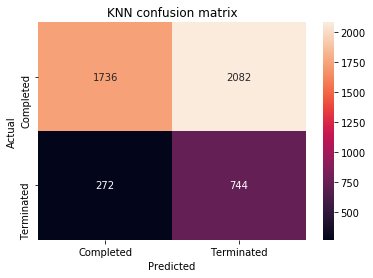

In [170]:
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN confusion matrix');

In [171]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.86      0.45      0.60      3818
  Terminated       0.26      0.73      0.39      1016

    accuracy                           0.51      4834
   macro avg       0.56      0.59      0.49      4834
weighted avg       0.74      0.51      0.55      4834



In [173]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, knn.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

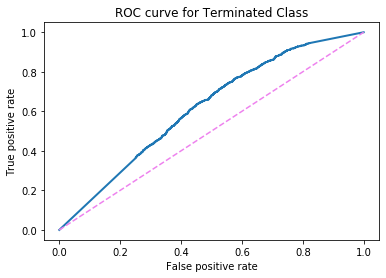

In [174]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [175]:
#The best threshold according to the ROC curve
thresholds[np.argmax(tpr - fpr)]

0.4967556244707593

In [47]:
y_validate_01 = []
for i in y_validate_cv1:
    if i=='Completed':
        y_validate_01.append(0)
    if i=="Terminated":
        y_validate_01.append(1)

In [50]:
F1_list = []
# Will take some time
for i in np.arange(0,1,0.2):
    preds = knn.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

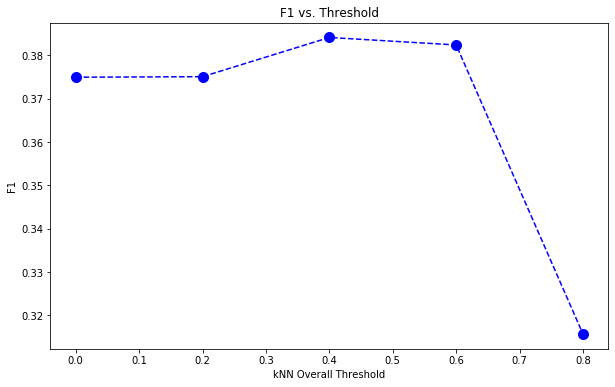

In [53]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.2), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("kNN Overall Threshold")
plt.ylabel("F1")

### Compared to a similar non-oversampled KNN model

In [124]:
knn.fit(X_train_cv1,y_train_cv1)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [125]:
preds = knn.predict(X_validate_cv1)

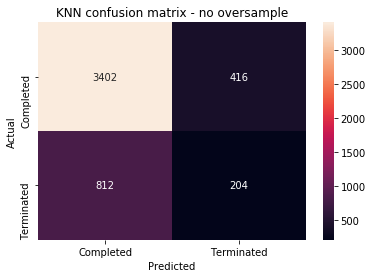

In [126]:
confusion = confusion_matrix(y_validate_cv1, preds)

sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN confusion matrix - no oversample');

Using oversampling was really important for kNN

In [194]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

knn.fit(X_adasyn,y_adasyn)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [195]:
with open('knn.pickle', 'wb') as write_file:
    pickle.dump(knn, write_file)

# Logistic Regression Optimization

Using class_weight=balanced for implicit oversampling here

In [15]:
#I determined that 'Terminated' is predicted as 1 and 'Completed' is predicted as 0
y_train_01 = []
for i in y_train:
    if i=='Completed':
        y_train_01.append(0)
    if i=="Terminated":
        y_train_01.append(1)

In [55]:
param_grid = [{'C': [0.1, 0.5, 1],
               'l1_ratio': [0, 0.5, 1]}]

search = GridSearchCV(LogisticRegression(class_weight='balanced', solver='saga', penalty='elasticnet', max_iter=500), \
                      param_grid, cv=3, n_jobs=-1, scoring='f1')

search.fit(X_train_scaled, y_train_01)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced', max_iter=500,
                                          penalty='elasticnet', solver='saga'),
             n_jobs=-1,
             param_grid=[{'C': [0.1, 0.5, 1], 'l1_ratio': [0, 0.5, 1]}],
             scoring='f1')

In [56]:
search.best_params_

{'C': 0.1, 'l1_ratio': 1}

Train/Validate split 67%:33%

In [8]:
skf = StratifiedKFold(n_splits=3)

In [9]:
train_index, test_index = next(iter(skf.split(X_train_scaled, y_train)))

In [10]:
X_train_cv1 = X_train_scaled[train_index]
X_validate_cv1 = X_train_scaled[test_index]

In [11]:
y_validate_cv1 = y_train.iloc[test_index]
y_train_cv1 = y_train.iloc[train_index]

In [57]:
lr = LogisticRegression(class_weight='balanced', solver='saga', C=0.1, l1_ratio=1, penalty='elasticnet',max_iter=500)

In [58]:
lr = lr.fit(X_train_cv1, y_train_cv1)

In [137]:
preds = lr.predict(X_validate_cv1)

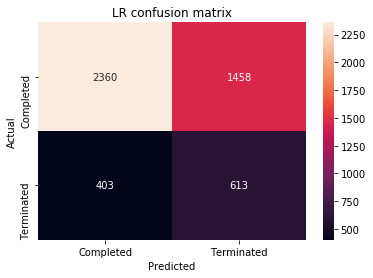

In [138]:
confusion = confusion_matrix(y_validate_cv1, preds)

sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LR confusion matrix');

In [139]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.85      0.62      0.72      3818
  Terminated       0.30      0.60      0.40      1016

    accuracy                           0.62      4834
   macro avg       0.58      0.61      0.56      4834
weighted avg       0.74      0.62      0.65      4834



In [229]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, lr.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

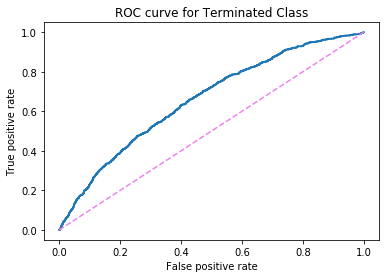

In [141]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [142]:
#The best threshold according to the ROC curve
thresholds[np.argmax(tpr - fpr)]

0.47569952487489936

In [29]:
y_validate_01 = []
for i in y_validate_cv1:
    if i=='Completed':
        y_validate_01.append(0)
    if i=="Terminated":
        y_validate_01.append(1)

In [145]:
print(classification_report(y_validate_01,lr.predict_proba(X_validate_cv1)[:,1] > 0.4757))

              precision    recall  f1-score   support

           0       0.86      0.57      0.69      3818
           1       0.29      0.66      0.40      1016

    accuracy                           0.59      4834
   macro avg       0.58      0.62      0.55      4834
weighted avg       0.74      0.59      0.63      4834



In [60]:
F1_list = []
for i in np.arange(0,1,0.1):
    preds = lr.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

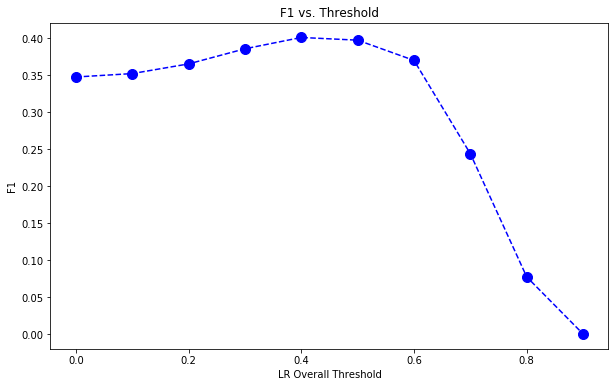

In [61]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.1), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("LR Overall Threshold")
plt.ylabel("F1")

In [197]:
lr = LogisticRegression(class_weight='balanced', solver='saga', \
                        C=0.1, l1_ratio=1, penalty='elasticnet',max_iter=500)

lr = lr.fit(X_train_scaled, y_train)

In [198]:
coefs = pd.DataFrame({'column':column_names,'coef':lr.coef_.flatten()}).sort_values('coef')

In [199]:
coefs

,column,coef
151,sponsor_Alliance for Clinical Trials in Oncology,-0.152527
147,sponsor_Memorial Sloan Kettering Cancer Center,-0.148971
145,sponsor_National Cancer Institute (NCI),-0.130703
169,China,-0.128382
149,sponsor_Eli Lilly and Company,-0.113230
...,...,...
154,sponsor_European Organisation for Research and...,0.125872
34,OversightHasDMC_Yes_basic,0.165697
99,Parallel Assignment_design,0.306869
101,Single Group Assignment_design,0.318542


In [200]:
coefs.head(20)

,column,coef
151,sponsor_Alliance for Clinical Trials in Oncology,-0.152527
147,sponsor_Memorial Sloan Kettering Cancer Center,-0.148971
145,sponsor_National Cancer Institute (NCI),-0.130703
169,China,-0.128382
149,sponsor_Eli Lilly and Company,-0.113230
218,Toronto,-0.095859
220,Wichita,-0.095820
58,bevacizumab_design,-0.092326
277,Sioux Falls,-0.088797
162,official_Dana-Farber Cancer Institute,-0.087624


In [203]:
coefs.tail(20)

,column,coef
10,leukemia_basic,0.075324
172,Canada,0.076082
255,Charleston,0.076086
56,surgery_design,0.076686
130,metasta_elig,0.077749
92,Diagnostic_design,0.078150
28,IsFDARegulatedDrug_Yes_basic,0.080065
263,Athens,0.080930
166,location_count,0.081129
234,Minneapolis,0.081935


In [201]:
with open('logistic_coefs.pickle', 'wb') as write_file:
    pickle.dump(coefs, write_file)

In [202]:
with open('logistic_regression.pickle', 'wb') as write_file:
    pickle.dump(lr, write_file)

# SVM optimization

In [18]:
param_grid = [{'kernel': ['linear','poly','rbf']}]

search = GridSearchCV(SVC(class_weight='balanced', probability=True, degree=2, C=0.1), \
                      param_grid, cv=2, n_jobs=-1, scoring='f1')
                      
search.fit(X_train_scaled, y_train_01)

GridSearchCV(cv=2,
             estimator=SVC(C=0.1, class_weight='balanced', degree=2,
                           probability=True),
             n_jobs=-1, param_grid=[{'kernel': ['linear', 'poly', 'rbf']}],
             scoring='f1')

In [19]:
search.best_params_

{'kernel': 'rbf'}

In [20]:
svc = SVC(class_weight='balanced', probability=True, C=0.1, \
          kernel = 'rbf' )

In [21]:
svc = svc.fit(X_train_cv1, y_train_cv1)

In [22]:
preds = svc.predict(X_validate_cv1)

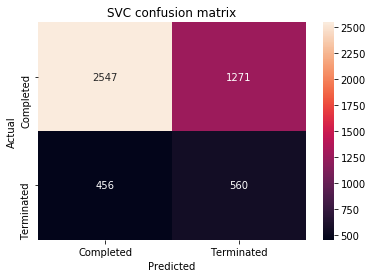

In [23]:
confusion = confusion_matrix(y_validate_cv1, preds)

sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVC confusion matrix');

In [24]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.85      0.67      0.75      3818
  Terminated       0.31      0.55      0.39      1016

    accuracy                           0.64      4834
   macro avg       0.58      0.61      0.57      4834
weighted avg       0.73      0.64      0.67      4834



In [25]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, svc.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

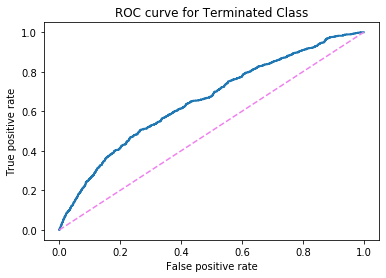

In [26]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [27]:
#The best threshold according to the ROC curve
thresholds[np.argmax(tpr - fpr)]

0.23969734354764274

In [30]:
F1_list = []
for i in np.arange(0,1,0.2):
    preds = svc.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

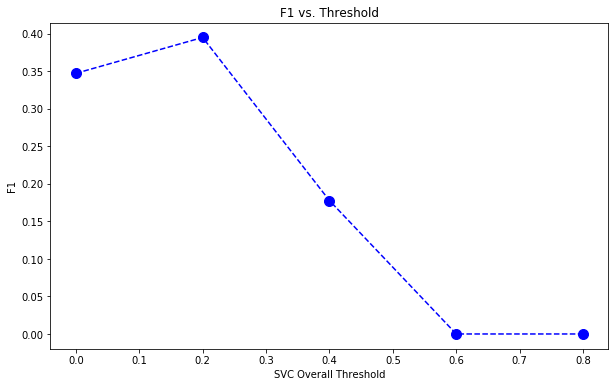

In [61]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.2), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("SVC Overall Threshold")
plt.ylabel("F1")

In [33]:
print(classification_report(y_validate_01,svc.predict_proba(X_validate_cv1)[:,1] > thresholds[np.argmax(tpr - fpr)]))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79      3818
           1       0.33      0.51      0.40      1016

    accuracy                           0.68      4834
   macro avg       0.59      0.62      0.59      4834
weighted avg       0.74      0.68      0.70      4834



In [34]:
svc = SVC(class_weight='balanced', probability=True, C=0.1, \
          kernel = 'rbf' )

svc.fit(X_train_scaled, y_train)

SVC(C=0.1, class_weight='balanced', probability=True)

In [35]:
with open('svc.pickle', 'wb') as write_file:
    pickle.dump(svc, write_file)

# Naive Bayes Optimization

MultinomialNB is going to work best with my dataset because I have a mix of 0/1 (Bernoulli) data, count (Multinomial) data and continous (Gaussian) data. Bernoulli would count all non-zero values as 1, and Gaussian wouldn't appropriately model my binary or count data.

Some values are less than 0 because of rounding errors with standard scaler retransofrming my scaled imputed data back to normal. I want to use non-scaled data here so the Multinomial data assumption is valid

In [38]:
for i in range(1,397):
    if X_train[:,i].min() < 0:
        print(i)
        #print(column_names[i])

19
21
51
52
53
114
123
147
186
206
244
277
289


In [39]:
X_train[:,19].min()

-1.3877787807814457e-17

In [40]:
X_train_df = pd.DataFrame(X_train)
X_train_df[(X_train_df < 0)] = 0
X_train_2 = np.array(X_train_df)
del X_train_df

In [41]:
y_train_01 = []
for i in y_train:
    if i=='Completed':
        y_train_01.append(0)
    if i=="Terminated":
        y_train_01.append(1)

In [42]:
#alpha is part of the equation for the psuedocount
param_grid = [{'alpha': [0.0000000001, 0.000001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]}]

search = GridSearchCV(MultinomialNB(), param_grid, cv=3, n_jobs=-1, \
                      scoring='f1')
                      
search.fit(X_train_2, y_train_01)

GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid=[{'alpha': [1e-10, 1e-06, 0.0001, 0.001, 0.005, 0.01,
                                    0.05, 0.1, 0.25, 0.5, 0.75, 1]}],
             scoring='f1')

In [43]:
search.best_params_

{'alpha': 1e-10}

In [44]:
train_index, test_index = next(iter(skf.split(X_train_2, y_train)))

In [45]:
X_train_cv1 = X_train_2[train_index]
X_validate_cv1 = X_train_2[test_index]

In [46]:
y_validate_cv1 = y_train.iloc[test_index]
y_train_cv1 = y_train.iloc[train_index]

In [47]:
nb = MultinomialNB(alpha=0.0000000001)
nb.fit(X_train_cv1, y_train_cv1)

MultinomialNB(alpha=1e-10)

In [48]:
preds=nb.predict(X_validate_cv1)

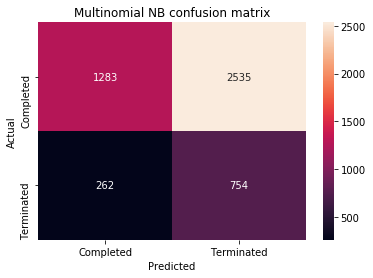

In [49]:
confusion = confusion_matrix(y_validate_cv1, preds)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multinomial NB confusion matrix');

In [50]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.83      0.34      0.48      3818
  Terminated       0.23      0.74      0.35      1016

    accuracy                           0.42      4834
   macro avg       0.53      0.54      0.41      4834
weighted avg       0.70      0.42      0.45      4834



In [51]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, nb.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

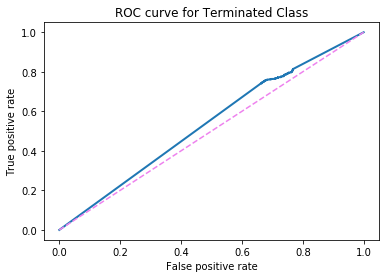

In [52]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [53]:
#The best threshold according to the ROC curve
thresholds[np.argmax(tpr - fpr)]

0.0036412744802954743

ComplementNB doc sheet says it is better suited to imbalanced classes than MultinomialNB, so I try this out as well

In [55]:
#alpha is part of the equation for the psuedocount
param_grid = [{'alpha': [0.0000000001, 0.000001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]}]

search = GridSearchCV(ComplementNB(), param_grid, cv=3, n_jobs=-1, \
                      scoring='f1')
                      
search.fit(X_train_2, y_train_01)

GridSearchCV(cv=3, estimator=ComplementNB(), n_jobs=-1,
             param_grid=[{'alpha': [1e-10, 1e-06, 0.0001, 0.001, 0.005, 0.01,
                                    0.05, 0.1, 0.25, 0.5, 0.75, 1]}],
             scoring='f1')

In [56]:
search.best_params_

{'alpha': 1e-10}

In [57]:
nb = ComplementNB(alpha=0.0000000001)
nb.fit(X_train_cv1, y_train_cv1)

ComplementNB(alpha=1e-10)

In [58]:
preds=nb.predict(X_validate_cv1)

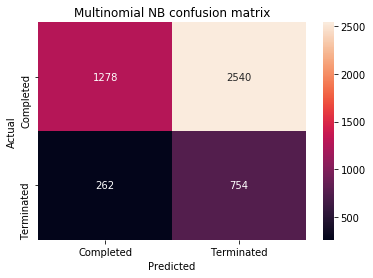

In [59]:
confusion = confusion_matrix(y_validate_cv1, preds)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multinomial NB confusion matrix');

In [60]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.83      0.33      0.48      3818
  Terminated       0.23      0.74      0.35      1016

    accuracy                           0.42      4834
   macro avg       0.53      0.54      0.41      4834
weighted avg       0.70      0.42      0.45      4834



In [69]:
F1_list = []
for i in np.arange(0,1,0.1):
    preds = nb.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

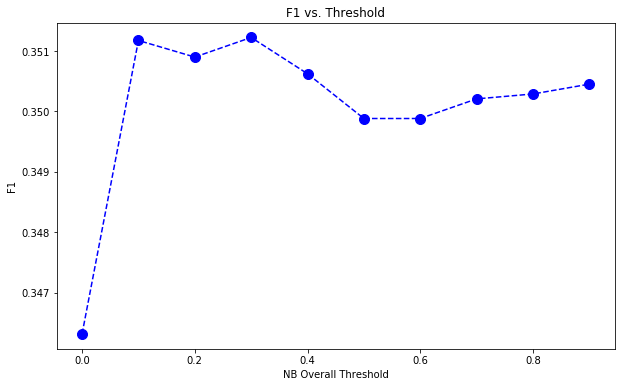

In [70]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.1), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("NB Overall Threshold")
plt.ylabel("F1")

In [72]:
print(classification_report(y_validate_01, nb.predict_proba(X_validate_cv1)[:,1] > 0.3))

              precision    recall  f1-score   support

           0       0.83      0.33      0.48      3818
           1       0.23      0.75      0.35      1016

    accuracy                           0.42      4834
   macro avg       0.53      0.54      0.41      4834
weighted avg       0.71      0.42      0.45      4834



I ultimately decide on Multinomial NB

In [73]:
nb = MultinomialNB(alpha=0.0000000001)
nb.fit(X_train, y_train)

MultinomialNB(alpha=1e-10)

In [74]:
with open('multinomial_nb.pickle', 'wb') as write_file:
    pickle.dump(nb, write_file)

In [263]:
del knn, lr, svc, nb

# Random Forest Optimization

In [8]:
skf = StratifiedKFold(n_splits=3)

In [9]:
train_index, test_index = next(iter(skf.split(X_train, y_train)))
X_train_cv1 = X_train[train_index]
X_validate_cv1 = X_train[test_index]
y_validate_cv1 = y_train.iloc[test_index]
y_train_cv1 = y_train.iloc[train_index]


In [10]:
train_index, test_index = next(iter(skf.split(X_train_scaled, y_train)))
X_train_cv2 = X_train_scaled[train_index]
X_validate_cv2 = X_train_scaled[test_index]
y_validate_cv2 = y_train.iloc[test_index]
y_train_cv2 = y_train.iloc[train_index]


In [11]:
train_index, test_index = next(iter(skf.split(X_train_scaled, y_train)))
X_train_cv3 = X_train_scaled[train_index]
X_validate_cv3 = X_train_scaled[test_index]
y_validate_cv3 = y_train.iloc[test_index]
y_train_cv3 = y_train.iloc[train_index]


In [22]:
def graph_param(param,range_of_interest):
    final_scores = []

    for i in range_of_interest:
        scores = []
        for cv in [(X_train_cv1, y_train_cv1,X_validate_cv1,y_validate_cv1), \
                 (X_train_cv2, y_train_cv2,X_validate_cv2,y_validate_cv2), \
                 (X_train_cv3, y_train_cv3,X_validate_cv3,y_validate_cv3)]:
            d={'max_features':i,'class_weight':'balanced'}
            rf = RandomForestClassifier(**d)
            rf.fit(cv[0], cv[1])
            score = f1_score(rf.predict(cv[2]), cv[3], pos_label="Terminated")
            scores.append(score)
        score=sum(scores)/len(scores)
        final_scores.append(score)
    
    x_vals=range_of_interest
    plt.plot(x_vals,final_scores)
    plt.xlabel(param, fontsize=12)
    plt.ylabel('f1', fontsize=12)

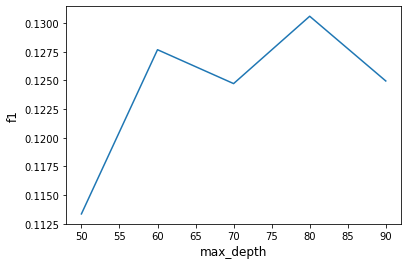

In [23]:
graph_param('max_depth',range(50,100,10)) #default=None is oK

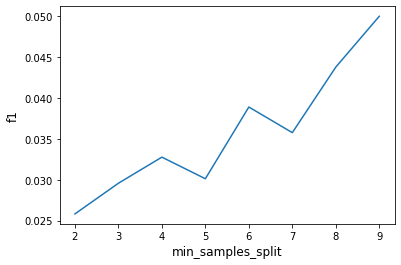

In [24]:
graph_param('min_samples_split',range(2,10)) # default=2 is not best

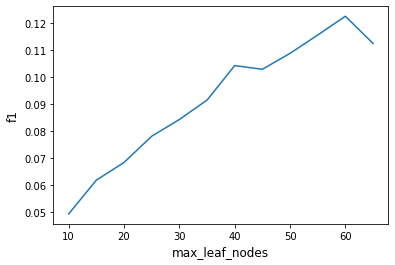

In [25]:
graph_param('max_leaf_nodes',range(10,70,5)) #default=None is OK

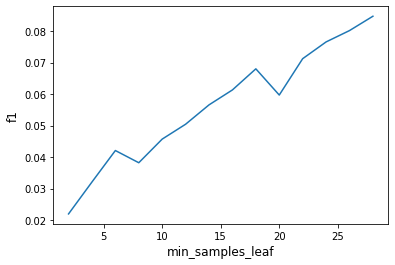

In [26]:
graph_param('min_samples_leaf',range(2,30,2)) #default=1 is NOT best

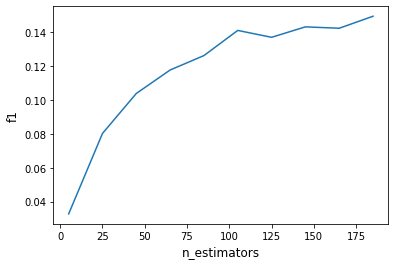

In [27]:
graph_param('n_estimators',range(5,205,20)) #default=100 is ok

In [28]:
np.sqrt(400) #default max_features

20.0

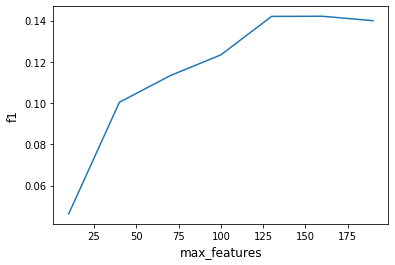

In [29]:
graph_param('max_features',range(10,200,30)) #default value 20 is not best

All the F1 scores are VERY low in the graphs

Random Forests are probably not going to work well for this dataset

# XGBoost

Originally I wasn't able to get this module to download, due to incompatibillities with my version of sklearn, so I was using the GradientBoostedClassifier from sklearn instead and it was performing as badly as the random forest - it is much more prone to overfitting than XGBoost, but I am not sure if my model ws underfit or overfit - will need to check on training set

In [1]:
import xgboost as xgb

In [9]:
y_train_01 = []
for i in y_train_cv1:
    if i=='Completed':
        y_train_01.append(0)
    if i=="Terminated":
        y_train_01.append(1)

In [10]:
y_validate_01 = []
for i in y_validate_cv1:
    if i=='Completed':
        y_validate_01.append(0)
    if i=="Terminated":
        y_validate_01.append(1)

In [29]:
#0.68 max validation for LR=0.5, min child weights =3


gbm = xgb.XGBRegressor(n_estimaters=3000, objective='binary:logistic', \
                      learning_rate=0.5, min_child_weight=3)

eval_set=[(X_train_cv1, y_train_01),(X_validate_cv1,y_validate_01)] #tracking train/validation error as we go
fit_model = gbm.fit(X_train_cv1, y_train_01, eval_set=eval_set, \
                    eval_metric='auc',early_stopping_rounds=20)

[0]	validation_0-auc:0.63714	validation_1-auc:0.625065
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.665734	validation_1-auc:0.631794
[2]	validation_0-auc:0.67275	validation_1-auc:0.643186
[3]	validation_0-auc:0.680773	validation_1-auc:0.645079
[4]	validation_0-auc:0.68586	validation_1-auc:0.645356
[5]	validation_0-auc:0.692825	validation_1-auc:0.651944
[6]	validation_0-auc:0.695836	validation_1-auc:0.657113
[7]	validation_0-auc:0.70379	validation_1-auc:0.658682
[8]	validation_0-auc:0.709693	validation_1-auc:0.663184
[9]	validation_0-auc:0.715336	validation_1-auc:0.665576
[10]	validation_0-auc:0.719208	validation_1-auc:0.665644
[11]	validation_0-auc:0.722001	validation_1-auc:0.666068
[12]	validation_0-auc:0.725996	validation_1-auc:0.66739
[13]	validation_0-auc:0.730109	validation_1-auc:0.670188
[14]	validation_0-auc:0.733494	validation_1-auc:0.671526
[15

In [30]:
gbm.best_ntree_limit

44

In [50]:
preds=gbm.predict(X_validate_cv1)

In [55]:
preds

array([0.06207483, 0.3444015 , 0.10024903, ..., 0.1129244 , 0.44800702,
       0.03788467], dtype=float32)

In [57]:
preds_bool = preds > 0.2

In [58]:
preds_bool

array([False,  True, False, ..., False,  True, False])

In [41]:
F1_list = []
for i in np.arange(0,1,0.1):
    preds = gbm.predict(X_validate_cv1) > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

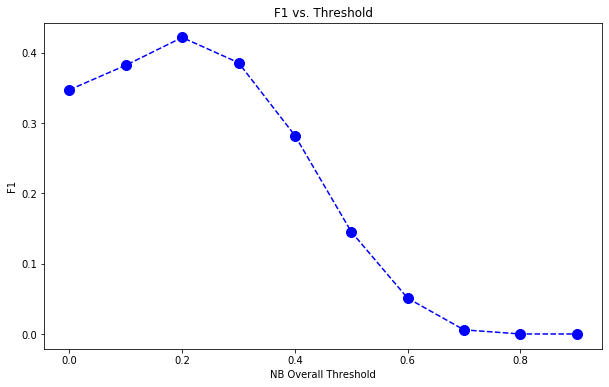

In [42]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.1), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("NB Overall Threshold")
plt.ylabel("F1")

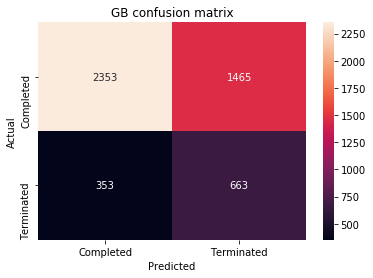

In [59]:
confusion = confusion_matrix(y_validate_01, preds_bool)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GB confusion matrix');

In [61]:
print(classification_report(y_validate_01, preds_bool))

              precision    recall  f1-score   support

           0       0.87      0.62      0.72      3818
           1       0.31      0.65      0.42      1016

    accuracy                           0.62      4834
   macro avg       0.59      0.63      0.57      4834
weighted avg       0.75      0.62      0.66      4834



In [62]:
with open('gbm.pickle', 'wb') as write_file:
    pickle.dump(gbm, write_file)